# House Prices Regression Analysis
This notebook follows a complete pipeline: EDA, preprocessing, modeling, and evaluation using linear models.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plot aesthetics
sns.set_context("paper", rc={"font.size":15, "axes.titlesize":15, "axes.labelsize":15})  
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score

# Dimensionality reduction (optional)
from sklearn.decomposition import PCA

# Inline plotting for Jupyter
%matplotlib inline


##  Load and Inspect the Data

In [2]:
#load the datasets and don't convert "NA" to NaN because it is an entry for 14 features 
#meaning that the house doesn't have that specific feature (eg. Alley, )
import pandas as pd

# Load normally with "NA" values as NaN
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Features where "NA" or "None" is a valid category 
na_is_valid = [
    'Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType'
]

# Restore 'NA' string in valid-category columns only (if it got converted to NaN)
for col in na_is_valid:
    if col in train.columns:
        train[col] = train[col].fillna('NA')
    if col in test.columns:
        test[col] = test[col].fillna('NA')

print("Train Shape:",train.shape)
print(train.head())

Train Shape: (1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave    NA      Reg   
1   2          20       RL         80.0     9600   Pave    NA      Reg   
2   3          60       RL         68.0    11250   Pave    NA      IR1   
3   4          70       RL         60.0     9550   Pave    NA      IR1   
4   5          60       RL         84.0    14260   Pave    NA      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
1         Lvl    AllPub  ...        0     NA    NA          NA       0      5   
2         Lvl    AllPub  ...        0     NA    NA          NA       0      9   
3         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
4         Lvl    AllPub  ...        0     NA    NA          NA       0     12   

  YrSold  SaleType  SaleCondition  SalePrice

In [3]:
print("Test Shape:",train.shape)
print(test.head())

Test Shape: (1460, 81)
     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave    NA      Reg   
1  1462          20       RL         81.0    14267   Pave    NA      IR1   
2  1463          60       RL         74.0    13830   Pave    NA      IR1   
3  1464          60       RL         78.0     9978   Pave    NA      IR1   
4  1465         120       RL         43.0     5005   Pave    NA      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0     NA  MnPrv          NA   
1         Lvl    AllPub  ...           0        0     NA     NA        Gar2   
2         Lvl    AllPub  ...           0        0     NA  MnPrv          NA   
3         Lvl    AllPub  ...           0        0     NA     NA          NA   
4         HLS    AllPub  ...         144        0     NA     NA          NA   

  MiscVal MoSold  YrSold  SaleType  SaleCondi

In [4]:
#check for data leakage between the test and train dataset using ID feature 
overlap = set(train['Id']).intersection(set(test['Id']))
print("Number of Overlapping values:", len(overlap))

#we are good! no data leakage according to common ID numbers 

Number of Overlapping values: 0


In [5]:
#set ID to index for the train datasets
train.set_index('Id', inplace=True) 
train.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500


In [6]:
#set ID to index for the test datasets
test.set_index('Id', inplace=True) 
test.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NA,Reg,Lvl,AllPub,Inside,...,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal


## Check for and Handle Missing Values

In [7]:
# Check nulls in train set
nulls = train.isnull().sum().to_frame(name='MissingValues')
#sorting by descending bc there's too many features
nulls.sort_values(by='MissingValues', ascending=False, inplace=True)
print(nulls.head(10))
#LotFrontage, MasVnrArea and Electrical all have missing values we will impute

             MissingValues
LotFrontage            259
MasVnrArea               8
Electrical               1
MSSubClass               0
Street                   0
Alley                    0
MSZoning                 0
LotArea                  0
Utilities                0
LotConfig                0


<Axes: ylabel='Id'>

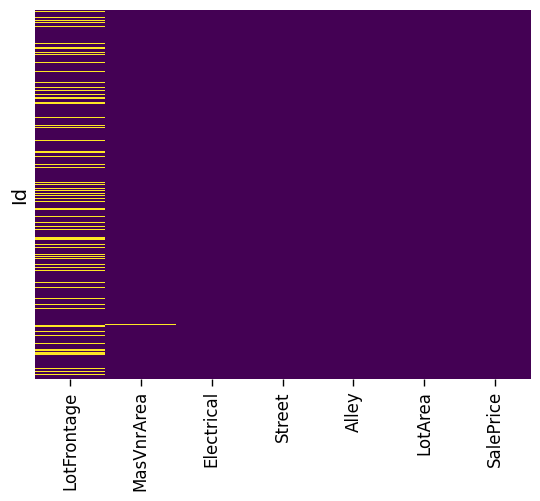

In [8]:
#visualize null values
nulls_train_viz=train[["LotFrontage", "MasVnrArea", "Electrical","Street","Alley", "LotArea","SalePrice"]]

sns.heatmap(nulls_train_viz.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [9]:
# Find datatypes of columns with null values
#Making sure target feature doesn't have nulls

train[["LotFrontage", "MasVnrArea", "Electrical","SalePrice"]].info()


<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   MasVnrArea   1452 non-null   float64
 2   Electrical   1459 non-null   object 
 3   SalePrice    1460 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 57.0+ KB


In [10]:
#instantiate the imputers 
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

#fit the imputers
train[["LotFrontage", "MasVnrArea"]] = num_imputer.fit_transform(train[["LotFrontage", "MasVnrArea"]])
train[["Electrical"]] = cat_imputer.fit_transform(train[["Electrical"]])

#Sanity check on the features
train[["LotFrontage", "MasVnrArea", "Electrical"]].info()


<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1460 non-null   float64
 1   MasVnrArea   1460 non-null   float64
 2   Electrical   1460 non-null   object 
dtypes: float64(2), object(1)
memory usage: 45.6+ KB


In [11]:
# Check nulls in test set
nulls_test = test.isnull().sum().to_frame(name='MissingValues')
#sorting by descending bc there's too many features
nulls_test.sort_values(by='MissingValues', ascending=False, inplace=True)
print(nulls_test.head(20))

#'LotFrontage', 'MasVnrArea', 'MSZoning', 'BsmtHalfBath', 'Functional', 'BsmtFullBath', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 
# 'SaleType', 'KitchenQual', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2' all have missing values we will impute

              MissingValues
LotFrontage             227
MasVnrArea               15
MSZoning                  4
BsmtHalfBath              2
Functional                2
BsmtFullBath              2
Utilities                 2
Exterior1st               1
Exterior2nd               1
BsmtUnfSF                 1
TotalBsmtSF               1
GarageCars                1
SaleType                  1
KitchenQual               1
GarageArea                1
BsmtFinSF1                1
BsmtFinSF2                1
Condition1                0
Neighborhood              0
BldgType                  0


<Axes: ylabel='Id'>

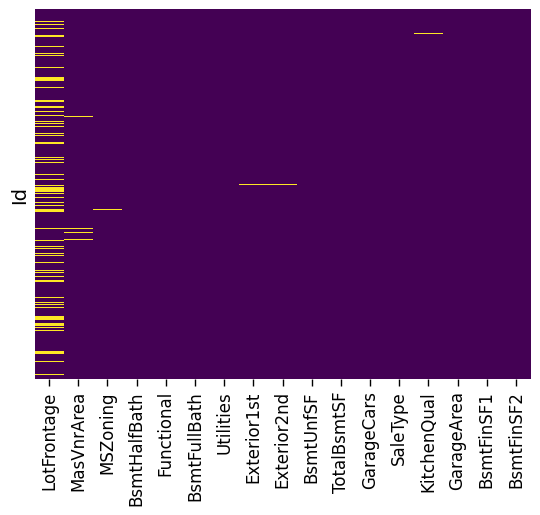

In [12]:
#visualize null values
nulls_test_viz=test[['LotFrontage', 'MasVnrArea', 'MSZoning', 'BsmtHalfBath', 'Functional', 'BsmtFullBath', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'SaleType', 'KitchenQual', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2']]

sns.heatmap(nulls_test_viz.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [15]:
# Find datatypes of columns with null values
#Making sure target feature doesn't have nulls

test[['LotFrontage', 'MasVnrArea', 'MSZoning', 'BsmtHalfBath', 'Functional', 'BsmtFullBath', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'SaleType', 'KitchenQual', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2']].info()


<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 1461 to 2919
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1232 non-null   float64
 1   MasVnrArea    1444 non-null   float64
 2   MSZoning      1455 non-null   object 
 3   BsmtHalfBath  1457 non-null   float64
 4   Functional    1457 non-null   object 
 5   BsmtFullBath  1457 non-null   float64
 6   Utilities     1457 non-null   object 
 7   Exterior1st   1458 non-null   object 
 8   Exterior2nd   1458 non-null   object 
 9   BsmtUnfSF     1458 non-null   float64
 10  TotalBsmtSF   1458 non-null   float64
 11  GarageCars    1458 non-null   float64
 12  SaleType      1458 non-null   object 
 13  KitchenQual   1458 non-null   object 
 14  GarageArea    1458 non-null   float64
 15  BsmtFinSF1    1458 non-null   float64
 16  BsmtFinSF2    1458 non-null   float64
dtypes: float64(10), object(7)
memory usage: 205.2+ KB


In [16]:
#long code so will define a new one
num_col = ['LotFrontage', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2']
cat_col = ['MSZoning','Functional','Utilities','Exterior1st','Exterior2nd','SaleType','KitchenQual']

#fit the imputers
test[num_col] = num_imputer.transform(test[num_col])
test[cat_col] = cat_imputer.transform(test[cat_col])

#Sanity check on the features
test[num_col + cat_col].info()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- BsmtFinSF1
- BsmtFinSF2
- BsmtFullBath
- BsmtHalfBath
- BsmtUnfSF
- ...


In [25]:
#Sanity check on the null values and new number of columns
print("Train shape:", train.shape)
print("Train nulls:", train.isnull().sum())
print("-"*30)
print("Test shape:", test.shape)
print("Test nulls:", test.isnull().sum())

Train shape: (1460, 80)
Train nulls: MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64
------------------------------
Test shape: (1459, 79)
Test nulls: MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
Street             0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 79, dtype: int64


## Exploratory Data Analysis (EDA)

In [ ]:
# Histogram to check the distribution of our target variable
plt.figure(figsize=(15, 5))
sns.histplot(data=train, x="SalePrice", kde=True)
plt.show()

In [ ]:
# 1) Print the skewness
# 2) print the kurtosis

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

# a lot of kurtosis because it has a really long tail

##### Independent variables: check the statistical properties of the numerical features 

In [ ]:
# Get the statistical properties of the numerical features

train.describe()

##### Correlation heatmap 

In [ ]:
# Get correlation matrix
corr_matrix = train.corr(numeric_only=True)

# Correlation with SalePrice
corr_target = corr_matrix['SalePrice'].drop('SalePrice')

# Get top 10 positively and 10 negatively correlated features
top_pos_corr = corr_target.sort_values(ascending=False).head(10)
top_neg_corr = corr_target.sort_values().head(10)
combined_corr = pd.concat([top_pos_corr, top_neg_corr])

# Plot as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(combined_corr.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title("Top Positively and Negatively Correlated Features with SalePrice")
plt.tight_layout()
plt.show()


In [ ]:
#Traditional sns box plot of the features against one another instead of our target variable
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot_kws={'size': 8}, 
            cmap="Spectral_r");

In [ ]:
#check on features scale against one another 

plt.figure(figsize=(15,5))
ax = sns.boxplot(data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show();

Encoding and Scaling

In [ ]:
#Ordinal encoding for certain features that are quality-based or ranked metrics

# One-hot encoding
train_encoded = pd.get_dummies(train, drop_first=True)
test_encoded = pd.get_dummies(test, drop_first=True)

# Align columns
X = train_encoded.drop(columns=['SalePrice', 'Id'])
y = train_encoded['SalePrice']
X_test = test_encoded.reindex(columns=X.columns, fill_value=0)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

## Step 6: Feature Importance

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_scaled_df, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Step 7: Modeling and Evaluation

In [ ]:
# Define models
from sklearn.pipeline import Pipeline
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Polynomial Regression (deg 2)': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('linreg', LinearRegression())])
}

# Use top features for poly regression
X_poly = X_scaled_df[top_features.index]
results = []

for name, model in models.items():
    if 'Polynomial' in name:
        model.fit(X_poly, y)
        y_pred = model.predict(X_poly)
    else:
        model.fit(X_scaled_df, y)
        y_pred = model.predict(X_scaled_df)
    
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    y_bin = pd.qcut(y, q=4, labels=False)
    y_pred_bin = pd.qcut(pd.Series(y_pred).rank(method='first'), q=4, labels=False)
    f1 = f1_score(y_bin, y_pred_bin, average='macro')
    results.append({'Model': name, 'Train RMSE': round(rmse, 2), 'Train R²': round(r2, 3), 'F1 Score': round(f1, 3)})

pd.DataFrame(results).sort_values(by='Train RMSE')